# Mammal Ensemble Language Model

This notebook trains a genomic language model on the data prepared in the __Mammal 0 Genomic Data Processing__ notebook. The model structure and training methodology for genomic language models is explained in the [E. coli 2 Genomic Pretraining](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%202%20Genomic%20Pretraining.ipynb) notebook.

This notebook is basically a ton of repetitive code because I had to break the training procedure into multiple chunks over several days.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

In [5]:
df_valid = pd.read_csv(path/'mammal_val.csv')

In [6]:
df_iter = pd.read_csv(path/'mammal_train.csv', chunksize=1000000)

In [7]:
df = next(df_iter)

In [8]:
df.head()

,Sequence,Source,set
0,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,NCBI Human,train
1,CATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGG...,NCBI Human,train
2,ACCTGCCCCACAGCCTTGCCTGGATTTCTATCTCCCTGGCTTGGTG...,NCBI Human,train
3,CTGGGGAAGCTTACTGTGTCCAAGAGCCTGCTGGGAGGGAAGTCAC...,NCBI Human,train
4,TGAAGATGGAGCCATATTCCTGCAGGCGCCCTGGAGCAGGGTACTT...,NCBI Human,train


In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=3, stride=1), n_cpus=8, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [10]:
data = GenomicTextLMDataBunch.from_df(path, df[:100000], df_valid, bs=800, tokenizer=tok, 
                              chunksize=50000, text_cols=0, label_cols=1, max_vocab=80000)

In [14]:
len(data.vocab.stoi), len(data.vocab.itos)

(65, 65)

In [15]:
np.save(path/'mammal_vocab_3m1s.npy', data.vocab.itos)

In [10]:
voc = np.load(path/'mammal_vocab_3m1s.npy')
model_vocab = GenomicVocab(voc)

In [11]:
data = GenomicTextLMDataBunch.from_df(path, df[:10000], df_valid[:10000], bs=800, tokenizer=tok, vocab=model_vocab, max_vocab=80000,
                              chunksize=50000, text_cols=0, label_cols=1)

In [12]:
len(data.vocab.itos), len(data.vocab.stoi)

(65, 65)

In [16]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult=0.3

In [17]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [19]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(65, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(65, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=65, bias=True)
    (output_dp): RNNDropout()
  )
)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


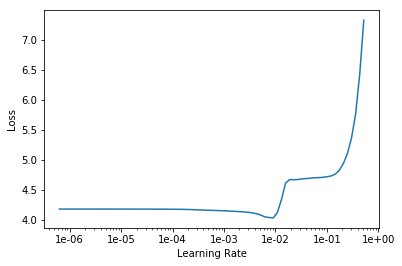

In [25]:
learn.recorder.plot()

0 - 1,000,000

In [22]:
count = 0
lr = 5e-3

dfs = [df[i:i+150000] for i in range(0, len(df), 150000)]

for df_chunk in dfs:
    data = GenomicTextLMDataBunch.from_df(path, df_chunk, df_valid, bs=850, tokenizer=tok, vocab=model_vocab, 
                                          max_vocab=80000, chunksize=50000, text_cols=0, label_cols=1)
    
    learn.data = data
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
    count += 1

Learning Rate: 0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.137214,1.129546,0.474920,59:19


Learning Rate: 0.0033333333333333335


epoch,train_loss,valid_loss,accuracy,time
0,1.122599,1.105048,0.490266,58:47


Learning Rate: 0.0022222222222222222


epoch,train_loss,valid_loss,accuracy,time
0,1.129296,1.097054,0.495411,58:53


Learning Rate: 0.0014814814814814814


epoch,train_loss,valid_loss,accuracy,time
0,1.099907,1.092845,0.496839,58:55


Learning Rate: 0.0009876543209876543


epoch,train_loss,valid_loss,accuracy,time
0,1.098669,1.087445,0.500447,58:51


Learning Rate: 0.0006584362139917696


epoch,train_loss,valid_loss,accuracy,time
0,1.107026,1.084222,0.502386,58:57


Learning Rate: 0.00043895747599451303


epoch,train_loss,valid_loss,accuracy,time
0,1.080230,1.085259,0.501632,41:13


In [23]:
learn.save('mammal_3m1s')
learn.save('mammal_3m1s_enc')

1,000,000 - 2,000,000

In [24]:
df = next(df_iter)

In [25]:
df.head()

,Sequence,Source,set
1000000,CATTGTTTTCATTCTCCATGACCGCTGTGGGTCACTTTCTATTATT...,NCBI Human,train
1000001,CACTTCAAAATGAAAAAATAATTATTGGAACTACATTGGGGGAACT...,NCBI Human,train
1000002,CAGTACAGCAGAATTCAAGGTCAGGGTAATTGCTTTCAGACAATAC...,NCBI Human,train
1000003,GATGGGGAAGAGTCAAGAACAGACAGCAGACGAGAAAAATAAATGA...,NCBI Human,train
1000004,AAGTAAATTGAAAACCTAGACAAGATTTTCCATTCTAGATGCCATT...,NCBI Human,train


In [26]:
count = 0
lr = 5e-3

dfs = [df[i:i+150000] for i in range(0, len(df), 150000)]

for df_chunk in dfs:
    data = GenomicTextLMDataBunch.from_df(path, df_chunk, df_valid, bs=850, tokenizer=tok, vocab=model_vocab, 
                                          max_vocab=80000, chunksize=50000, text_cols=0, label_cols=1)
    
    learn.data = data
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
    count += 1

Learning Rate: 0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.093412,1.084496,0.502619,59:02


Learning Rate: 0.0033333333333333335


epoch,train_loss,valid_loss,accuracy,time
0,1.055007,1.080925,0.504626,59:00


Learning Rate: 0.0022222222222222222


epoch,train_loss,valid_loss,accuracy,time
0,1.042854,1.072670,0.509128,58:59


Learning Rate: 0.0014814814814814814


epoch,train_loss,valid_loss,accuracy,time
0,1.119582,1.074671,0.508158,59:03


Learning Rate: 0.0009876543209876543


epoch,train_loss,valid_loss,accuracy,time
0,1.121611,1.073879,0.508647,59:05


Learning Rate: 0.0006584362139917696


epoch,train_loss,valid_loss,accuracy,time
0,1.118912,1.073103,0.508934,59:03


Learning Rate: 0.00043895747599451303


epoch,train_loss,valid_loss,accuracy,time
0,1.123445,1.074130,0.508497,41:19


In [27]:
learn.save('mammal_3m1s')
learn.save('mammal_3m1s_enc')